---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

In [3]:
# Centralized setup
import sys
from pathlib import Path

# Make sure PROJECT_PATH is in sys
PROJECT_ROOT = Path.cwd().resolve().parent
PROJECT_PATH = PROJECT_ROOT / "src" / "project"

if str(PROJECT_PATH) not in sys.path:
    sys.path.insert(0, str(PROJECT_PATH))

# Centralized import
from imports import *

---
# 2 - DATASET LOAD

### 2.1 - LOADING

In [4]:
X_train_path = "../data/processed/01_X_train_feat_engeneered.xlsx"
y_train_path = "../data/interim/02_y_train_aftersplit.xlsx"

X_test_path = "../data/processed/01_X_test_feat_engeneered.xlsx"
y_test_path = "../data/interim/02_y_test_aftersplit.xlsx"

try:
    X_train = utils.load_student_dataset(X_train_path)
    print('X_train successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    y_train = utils.load_student_dataset(y_train_path)
    print('y_train loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    X_test = utils.load_student_dataset(X_test_path)
    print('X_test successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    y_test = utils.load_student_dataset(y_test_path)
    print('y_test loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

X_train = X_train.drop(columns=["FamilyCapitalScore", "EngagementIndex"])
X_test = X_test.drop(columns=["FamilyCapitalScore", "EngagementIndex"])

X_train successfully.
y_train loaded successfully.
X_test successfully.
y_test loaded successfully.


---
# 3 - MODELING

### 3.1 - BASELINE

**Baseline Model**

Before testing more complex models, I thought I'd establish a **baseline**.  
The baseline gives me a simple benchmark: if my machine learning models can’t do better than this, then something is clearly wrong with either my features or my modeling approach.

**My baseline strategy**

Since this is a regression task, I will use the simplest possible predictor:  
**always predict the mean** of the training target (`y_train`).  

This is like me saying:  
> “No matter who the student is, I’ll just guess their GPA is about the average of the training set.”

**Steps I follow**
1. I compute the **mean GPA** from my training data.  
2. For every student in the test set, I predict this mean value.  
3. I then evaluate these predictions using standard error metrics:
   - **RMSE** (Root Mean Squared Error) - This is like the "average size of the mistake," but big errors count extra because they are squared. If RMSE is low, the model rarely makes very large mistakes.  
   - **MAE** (Mean Absolute Error) - This is the average absolute difference between predictions and the real values. Easier to interpret, but it does not punish big mistakes as much as RMSE.
   - **R²** (Coefficient of Determination) - This tells me how much of the variation in the data the model can explain. R² = 1.0 means perfect predictions, R² = 0 means the model is no better than guessing the mean and negative values mean it performs worse than the baseline.

**How to read them together**
Lower RMSE and MAE are better, since they mean smaller errors.
Higher R² is better, since it means the model explains more of the data.
RMSE and MAE show how far off the predictions are, while R² shows how accurate the model is overall.

**What I expect**
- **RMSE / MAE** should be relatively high, since many students deviate from the mean.  
- **R²** will be close to 0, or even negative if the test mean differs from the training mean.  

Even though this baseline is simple (and bad), it’s important:  
- It gives me a **minimum benchmark**.  
- Any useful regression model I build should clearly beat this by showing **lower RMSE/MAE** and a **higher R²**.

In [5]:
# Baseline (mean)
baseline_pred, baseline_metrics = preprocessing.baseline_mean_model(y_train, y_test)

# Print results
print("Baseline (Mean Predictor)")
print(f"RMSE: {baseline_metrics['RMSE']:.4f}")
print(f"MAE:  {baseline_metrics['MAE']:.4f}")
print(f"R²:   {baseline_metrics['R2']:.4f}")

Baseline (Mean Predictor)
RMSE: 0.9252
MAE:  0.7843
R²:   -0.0000


As expected, the baseline model has a very poor performance. 
1. **RMSE ≈ 0.9252**

This means that, on average, the baseline predictions (always predicting the training mean) are off by about 0.93 GPA units in squared-error sense.
RMSE penalizes larger errors more heavily.

2. **MAE ≈ 0.7843**

On average, the absolute difference between the predicted mean GPA and the actual GPAs in the test set is 0.78.
More intuitive than RMSE: “on average I’m ~0.8 GPA points wrong.”

3. **R² ≈ -0.0000**

R² is basically 0 (slightly negative due to tiny numerical differences).
Interpretation: this baseline explains no variance in the target. The best the model can do is guessing the average value every time.

This is *exactly what I expected*: predicting a constant (the mean) gives R² = 0 by definition and can dip slightly below zero if the test mean differs from the train mean.

### 3.2 - MODELS TRAINING AND COMPARISON

After setting the baseline, it’s time to move into the real modeling stage.  
Here I train and compare a set of regression algorithms on the student engagement dataset.  

To evaluate fairly, I use **5-fold cross-validation** on the training set: the data is split into 5 parts, the model is trained on 4 parts and validated on the remaining one, and the process repeats until every fold has been used.  
This gives me a reliable estimate of how each model performs before I select the best candidate to test on the unseen test set.

The models I will try, explained in simple terms and with analogies:

**Linear Regression (plus Ridge / Lasso)**  
Linear regression searches for the best straight-line (or flat surface in many dimensions) relationship between the input features and 'GPA'.  
- Ridge and Lasso are stricter versions that shrink large coefficients, preventing the model from chasing every small fluctuation.  
- They help keep the model simpler and more stable.  

> Analogy: drawing a smooth line through a cloud of points. Ridge and Lasso act like weights keeping the line steady so it doesn’t bend too much to follow one odd outlier.

**Decision Tree**  
Decision trees split the data into groups by asking a sequence of yes/no questions.  
For example: *Does the student study more than 5 hours per week?* If yes, go one way; if no, go another, and continue until a prediction is made.  

> Analogy: a checklist a teacher might use - *If the student studies a lot and rarely misses school, assume a higher GPA. Otherwise, follow the next question down the list…*

**Random Forest**  
A random forest combines the predictions of many different decision trees.  
Each tree sees a slightly different version of the data, and their answers are averaged to reduce the effect of noise or bias.  

> Analogy: instead of trusting one teacher’s opinion, I ask a panel of teachers and average their GPA predictions. The diversity of viewpoints produces a more balanced result.

**Gradient Boosting Regressor**  
Gradient boosting also uses trees but in a step-by-step manner.  
The first tree makes a rough guess, the next tree learns from its mistakes, and each new tree keeps improving on the previous ones.  

> Analogy: a student with several tutors in sequence - the first covers the basics, the next focuses on weaknesses, the last fills remaining gaps, until mastery is reached.

**Support Vector Regression (SVR)**  
SVR fits a line or curve through the data but allows a margin of tolerance.  
It focuses on capturing the overall trend instead of fitting every point exactly.  

> Analogy: stretching an elastic band across scattered data points - it won’t snap to each one, but follows the overall shape.

**k-Nearest Neighbors (KNN) Regression**  
KNN predicts 'GPA' by finding the 'k' most similar students in the training data and averaging their outcomes.  
For example, with 'k=5', the model looks for 5 students with similar study time, absences, or support, and uses their average GPA as the prediction.  

> Analogy: moving to a new class and asking 5 classmates who are most like you what grades they got — averaging their answers gives you a reasonable guess.

By comparing these different approaches, I can see which algorithm captures the patterns in the data best.  
Each method has unique strengths, and evaluating them side by side provides both **insight into the problem** and a **solid performance benchmark**.


In [6]:
# Define feature lists first
numeric_features = [
    "Age", "StudyTimeWeekly", "Absences",
    "FamilyCapitalScore", "EngagementIndex"
]

categorical_features = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"
]

results_df, best_name, best_pipe, test_metrics = preprocessing.run_model_suite(
    X_train, y_train,
    numeric_features, categorical_features,
    k_best=12,
    cv_splits=5,
    X_test=None, y_test=None  # optional
)

print("\n Metrics Summary (lower RMSE/MAE is better, higher R² is better):\n")
print(results_df.to_string(index=False))
print("\nBest by CV RMSE:", best_name)
if test_metrics:
    print("Test metrics:", {k: round(v, 4) for k, v in test_metrics.items()})


ValueError: A given column is not a column of the dataframe

In [ ]:
all_names, scores, mask, selected = preprocessing.get_selected_features(best_pipe, numeric_features, categorical_features)
print("\nSelected features (final fit):", selected[:25], "..." if len(selected) > 25 else "")


Selected features (final fit): ['StudyTimeWeekly', 'Absences', 'FamilyCapitalScore', 'Tutoring_0', 'Tutoring_1', 'ParentalSupport_0', 'ParentalSupport_3', 'ParentalSupport_4', 'Extracurricular_0', 'Extracurricular_1', 'Music_0', 'Music_1'] 


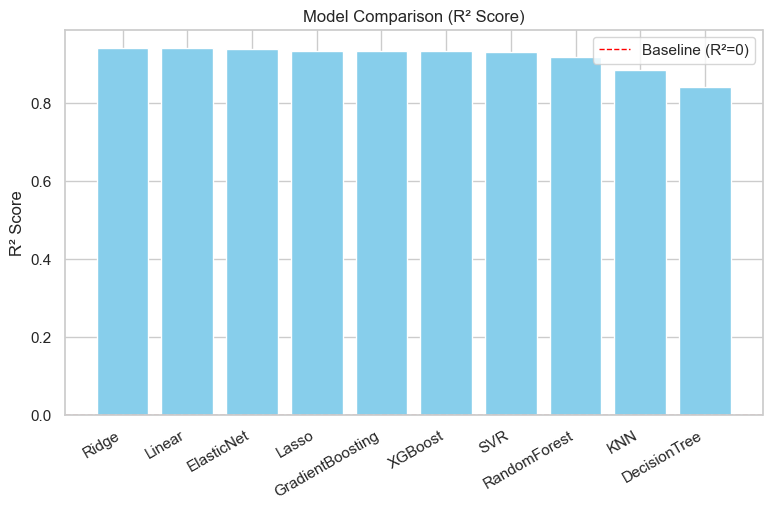

In [ ]:
preprocessing.plot_model_r2(results_df)  # automatically extracts Model vs R2

**Top performers (Ridge, Linear, ElasticNet)**

>- Ridge (RMSE = 0.224, R² = 0.940) and Linear Regression (RMSE = 0.224, R² = 0.940) are essentially tied.

>- ElasticNet is very close behind (RMSE ≈ 0.228, R² ≈ 0.938).

This means the data has strong linear relationships with GPA and regularized linear models capture them very well.

Ridge slightly edges out plain Linear Regression (by ~0.00002 in RMSE!) — practically identical performance, but Ridge gives a bit more stability if features are correlated.

**Middle ground (Lasso, GradientBoosting, SVR)**

>- Lasso (RMSE = 0.235, R² = 0.933) lags slightly: it forces some coefficients to zero, which may have thrown away small but useful features.

>- Gradient Boosting (RMSE = 0.236, R² = 0.933) and SVR (RMSE = 0.241, R² = 0.930) also perform well but not better than linear models.

This suggests the dataset doesn’t benefit much from complex nonlinear models — the structure is mostly linear.

**Weaker models (RandomForest, KNN, DecisionTree)**

>-Random Forest (RMSE = 0.262, R² = 0.917) does okay but worse than linear models.

>-KNN (RMSE = 0.312, R² = 0.883) and Decision Tree (RMSE = 0.365, R² = 0.839) perform significantly worse.

These models may be struggling because GPA is smooth and continuous, and simple distance- or split-based learners can’t capture it as well without very careful tuning.

**Key takeaway**

>- Linear models dominate: Ridge, plain Linear, and ElasticNet are the clear winners.

>- The fact that Ridge/Linear are better than Gradient Boosting and Random Forest shows the target (GPA) is strongly tied to linear effects of the features.

>- Regularization (Ridge, ElasticNet) helps ensure stability, but doesn’t drastically change results because the data seems clean and well-structured.

### 3.3 - LEARNING CURVE (RIDGE)

**Learning Curves for Model Diagnosis**

Learning curves show how a model’s performance evolves as the size of the training set increases.  
They are like growth charts for your model: they reveal whether performance is improving, plateauing, or diverging.

**Why they matter:**
- Diagnose bias vs. variance issues.
- Understand whether more data would help.
- Compare model capacity and generalization.

**Curve Interpretation:**
- **Converging curves at high performance** → Good fit.  
- **Large gap between train & validation** → Overfitting (high variance).  
- **Both plateau at low performance** → Underfitting (high bias).  
- **Validation still rising** → More data would help.


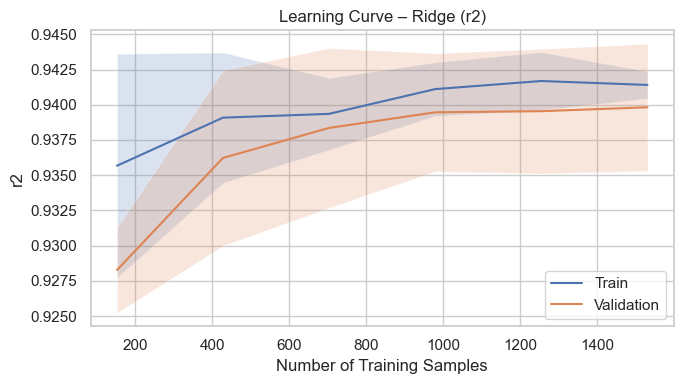

In [ ]:
# Stessa CV della suite (5 fold con shuffle)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Scegli lo scoring coerente con i tuoi report (esempi):
#    - "r2"
#    - "neg_root_mean_squared_error"
#    - "neg_mean_absolute_error"
scoring = "r2"

# y come Serie 1D (evita warning/errore)
y_tr = y_train.squeeze()

# Esegui per la pipeline migliore
preprocessing.plot_learning_curve(best_pipe, best_name, X_train, y_tr, cv=cv, scoring=scoring)


**Results (R²)**

- **Training curve**: starts at ~0.936 (with fewer samples) and increases as more data is used.  
- **Validation curve**: starts just above ~0.9275, then improves steadily.  
- **Both curves converge** around ~1000 training samples, reaching similar performance.  

**Interpretation:**  
The model generalizes well. The fact that the validation score keeps rising and then aligns with the training score indicates that with sufficient data (~1000+ samples), the model achieves a stable and reliable fit.

### 3.4 - HYPERPARAMETER TUNING (LINEAR MODELS)

**Why tune hyperparameters?**  
Linear models like Ridge and ElasticNet require regularization strength (`alpha`) and, in ElasticNet, the L1/L2 mixing (`l1_ratio`). These parameters control how much coefficients are shrunk, affecting both predictive accuracy and generalization.

Default settings are a reasonable starting point, but they’re rarely optimal.  
Here I tune the main hyperparameters of the linear family that worked best so far: 'Ridge' (strength 'alpha') and 'ElasticNet' (both 'alpha' and 'l1_ratio'). Linear Regressor has no hyperparameters.

**What I do**
- I wrap preprocessing and modeling in one pipeline so tuning is cross-validation safe.
- I use 5-fold cross-validation and optimize for **RMSE** (lower is better).
- I compare the tuned scores against the defaults, then keep the best configuration.

> Why this matters: the regularization strength controls how much the model shrinks coefficients. Too little → noisy, too much → underfit. Tuning finds the sweet spot for this dataset.

**Why RMSE and not R²?**  
- **RMSE (Root Mean Squared Error)** directly measures the *average prediction error* in the same units as the target (e.g., GPA points, °C, etc.).  
- **R²** is a relative metric that compares the model to a constant baseline (mean predictor). It can be misleading: two models with very similar RMSE may differ in R² depending on target variance.  
- For **model selection**, minimizing absolute error magnitudes (RMSE) is more stable and interpretable than maximizing explained variance (R²). Once tuned, you can still report R² alongside RMSE/MAE.

**Outcome I expect**
- A small but consistent improvement over defaults for 'Ridge'.
- For 'ElasticNet', a useful check whether adding L1 (sparsity) helps or not in this data.


In [ ]:
from sklearn.linear_model import Ridge, ElasticNet

# Define your feature lists first
# numeric_features = [...]
# categorical_features = [...]

# 1) Ridge tuning
ridge_params = {"model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_best_pipe, ridge_best_params, ridge_results, ridge_grid = preprocessing.tune_model(
    X_train, y_train,
    numeric_features, categorical_features,
    model=Ridge(),
    param_grid=ridge_params,
    k_best=12, cv_splits=5
)

# 2) Linear has no hyperparameters by definition

# 3) ElasticNet tuning
elastic_params = {
    "model__alpha":    [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.2, 0.5, 0.8]
}
elastic_best_pipe, elastic_best_params, elastic_results, elastic_grid = preprocessing.tune_model(
    X_train, y_train,
    numeric_features, categorical_features,
    model=ElasticNet(max_iter=10000),
    param_grid=elastic_params,
    k_best=12, cv_splits=5
)

Best params: {'model__alpha': 1.0}
Best CV RMSE: 0.223587
Best params: {'model__alpha': 0.001, 'model__l1_ratio': 0.2}
Best CV RMSE: 0.223584


**What I Did**

- **Models:** Ridge, ElasticNet.
- **Pipeline:** `ColumnTransformer` (scaling numeric + one-hot on categoricals) → `SelectKBest(k=12)` → model.  
  Preprocessing is *inside* the `Pipeline` so each CV fold fits transformers only on its training split.
- **Targets & Metric:** Regression on `GPA` (or your target); **primary metric = RMSE**.  
  Used a scorer returning **negative RMSE** so `GridSearchCV` can maximize; results reported below are **positive RMSE** for readability.
- **Cross-Validation:** `KFold(n_splits=5, shuffle=True, random_state=42)`.
- **Search space:**
  - Ridge: `alpha ∈ {0.001, 0.01, 0.1, 1.0, 10.0, 100.0}`  
  - ElasticNet: `alpha ∈ {0.001, 0.01, 0.1, 1.0, 10.0}`, `l1_ratio ∈ {0.2, 0.5, 0.8}`, `max_iter=10000`
- **Determinism:** fixed seeds where available (`random_state=42`); note that parallelism can introduce tiny numeric jitter.

**Why these models.**
- **Ridge** controls coefficient magnitude via L2; good default when many correlated features.
- **ElasticNet** blends L1/L2 (feature selection + stability), useful if we expect sparse signals.

**Interpretation of results.**
- **RMSE** differences below ~1e-3 are practically negligible in this dataset; prefer simpler configs unless ElasticNet’s sparsity adds value (interpretability, smaller model).

**Results — Linear Models (CV on training data)**

- **Ridge**
  - **Best params:** `{'model__alpha': 1.0}`
  - **Best CV RMSE:** **0.223587**

- **ElasticNet**
  - **Best params:** `{'model__alpha': 0.001, 'model__l1_ratio': 0.2}`
  - **Best CV RMSE:** **0.223584**

**Notes.**
- The RMSE difference between ElasticNet and Ridge is **0.000003**, i.e., **practically identical** in performance.
- Given the tie, I coukd:
  - **Choose Ridge(α=1.0)** as the **simpler** and more stable baseline, or
  - Pick **ElasticNet(α=0.001, l1_ratio=0.2)** if you value **some L1 shrinkage** (potential for sparser coefficients).

  I prioritize stability, so I picked Ridge. 

### 3.5 - FINALIZE MODEL (RIDGE)

After tuning, I am now reusing the best pipeline with the chosen parameters for Ridge and re-fitting on the entire `X_train` and `y_train` without any cross-validation. This will give my final model. 

In [ ]:
final_pipe = preprocessing.create_pipeline(
     numeric_features, categorical_features,
     k_best=12,
     model=Ridge(alpha=ridge_best_params["model__alpha"])
 )

final_pipe.fit(X_train, y_train.squeeze())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'StudyTimeWeekly',
                                                   'Absences',
                                                   'FamilyCapitalScore',
                                                   'EngagementIndex']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Ethnicity',
                                                   'ParentalEducation',
                                                   'Tutoring',
                                                   'ParentalSupport',
                                                   'Extracurricular', 'Sports',
                                                   'Music',
                                                   'Volunteering'])])),
                ('select',
                 SelectKBest(k=12,
                             score_func=<function f_regression at 0x000002091EABF880>)),
                ('model', Ridge())])

### 3.6 - MODEL PERFORMANCE AND INTERPRETATION

**Feature Insight: Coefficients & Importances**

**Goal.** Understand what drives the predictions:  
- For **linear models** (Ridge, Linear Regression, ElasticNet): I am looking at **coefficients** (in standardized space → sign/direction of effect).  
- For **tree-based models** (Random Forest): Iam looking at **feature importances** (average impurity reduction).  

**Why after tuning?**  
Interpretation is meaningful on the **final tuned model** (full fit, optimized hyperparameters). A quick comparison with other models (Linear, ElasticNet, RF) helps check **consistency**: if different families highlight the same features, confidence in the conclusions increases.  

**How to read them.**  
In linear models like Ridge, coefficients provide insights into feature importance:

- **Magnitude** → shows the strength of influence (larger absolute values = stronger impact).  
- **Sign** → tells the direction of the effect (positive = increases GPA, negative = decreases GPA).  
- **Relative ranking** → allows comparison of which features matter more, *within the same model*.  
- Since features are standardized before fitting, coefficients can be compared on the same scale.  

**Random Forest importances:** higher value = feature more used to reduce error in splits.

**How to Read the Results**

- **Ridge vs Linear vs ElasticNet:**  
  If signs are consistent and the same top features recur, the *story* told by your features is robust. Small differences between Linear and ElasticNet are expected (ElasticNet can push some weights closer to zero).  

- **RandomForest importances:**  
  If the top features overlap with those in the linear models, you can cite this as **triangulation**: very different model families point to the same drivers.  

- **Consensus score:**  
  Summarizes how consistently a feature is important across all models (0–1 scale). High consensus features are strong candidates for interpretation, reporting, or further feature engineering.


Ridge coefficients:


,feature,weight,abs_weight,model
1,Absences,-0.830968,0.830968,Ridge (tuned)
7,ParentalSupport_4,0.320065,0.320065,Ridge (tuned)
5,ParentalSupport_0,-0.230853,0.230853,Ridge (tuned)
6,ParentalSupport_3,0.184430,0.184430,Ridge (tuned)
0,StudyTimeWeekly,0.170916,0.170916,Ridge (tuned)
3,Tutoring_0,-0.124540,0.124540,Ridge (tuned)
4,Tutoring_1,0.124540,0.124540,Ridge (tuned)
8,Extracurricular_0,-0.093224,0.093224,Ridge (tuned)
9,Extracurricular_1,0.093224,0.093224,Ridge (tuned)
10,Music_0,-0.075092,0.075092,Ridge (tuned)


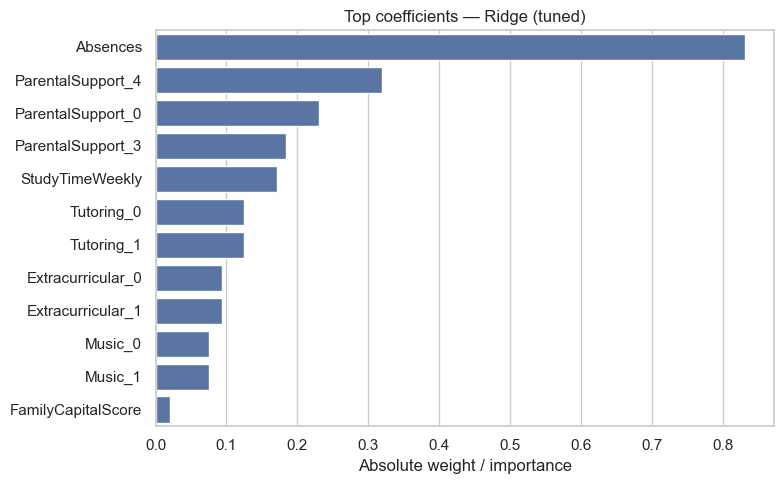

Coefficients across linear models:


,feature,ridge_w,linear_w,elastic_w
0,Absences,-0.830968,-0.831414,-0.830538
8,ParentalSupport_4,0.320065,0.323512,0.314437
6,ParentalSupport_0,-0.230853,-0.232961,-0.226928
7,ParentalSupport_3,0.184430,0.185954,0.181604
9,StudyTimeWeekly,0.170916,0.170991,0.170695
10,Tutoring_0,-0.124540,-0.124691,-0.134847
11,Tutoring_1,0.124540,0.124691,0.113162
1,Extracurricular_0,-0.093224,-0.093306,-0.103357
2,Extracurricular_1,0.093224,0.093306,0.082242
4,Music_0,-0.075092,-0.075128,-0.077344


Random Forest Feature Importance:


,feature,weight,abs_weight,model
1,Absences,0.852545,0.852545,RandomForest
0,StudyTimeWeekly,0.074672,0.074672,RandomForest
2,FamilyCapitalScore,0.020181,0.020181,RandomForest
3,Tutoring_0,0.007786,0.007786,RandomForest
5,ParentalSupport_0,0.007736,0.007736,RandomForest
4,Tutoring_1,0.007327,0.007327,RandomForest
7,ParentalSupport_4,0.007110,0.007110,RandomForest
6,ParentalSupport_3,0.006191,0.006191,RandomForest
8,Extracurricular_0,0.005349,0.005349,RandomForest
9,Extracurricular_1,0.005007,0.005007,RandomForest


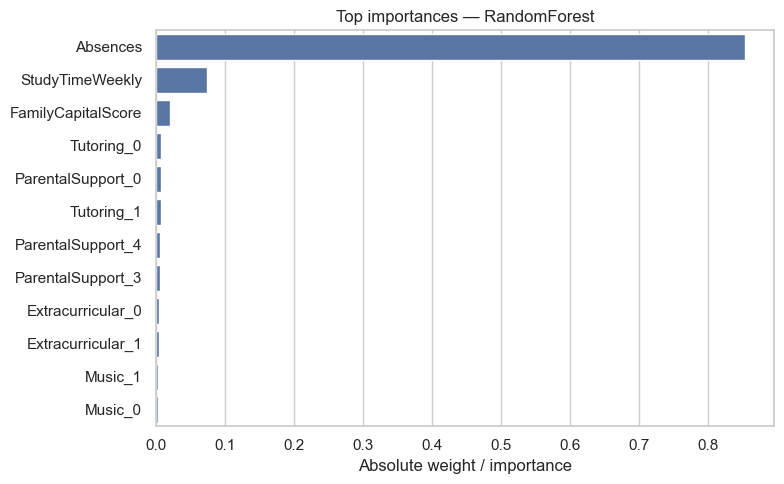

Consensus across models (normalized abs weights):


,feature,ridge,linear,elastic,rf,consensus_score
0,Absences,0.354542,0.353654,0.356572,0.852545,0.479328
8,ParentalSupport_4,0.136559,0.137611,0.134996,0.007110,0.104069
6,ParentalSupport_0,0.098496,0.099093,0.097426,0.007736,0.075688
9,StudyTimeWeekly,0.072923,0.072734,0.073284,0.074672,0.073403
7,ParentalSupport_3,0.078689,0.079098,0.077968,0.006191,0.060486
10,Tutoring_0,0.053136,0.053039,0.057894,0.007786,0.042964
11,Tutoring_1,0.053136,0.053039,0.048584,0.007327,0.040522
1,Extracurricular_0,0.039775,0.039689,0.044374,0.005349,0.032297
2,Extracurricular_1,0.039775,0.039689,0.035309,0.005007,0.029945
4,Music_0,0.032039,0.031957,0.033206,0.003018,0.025055


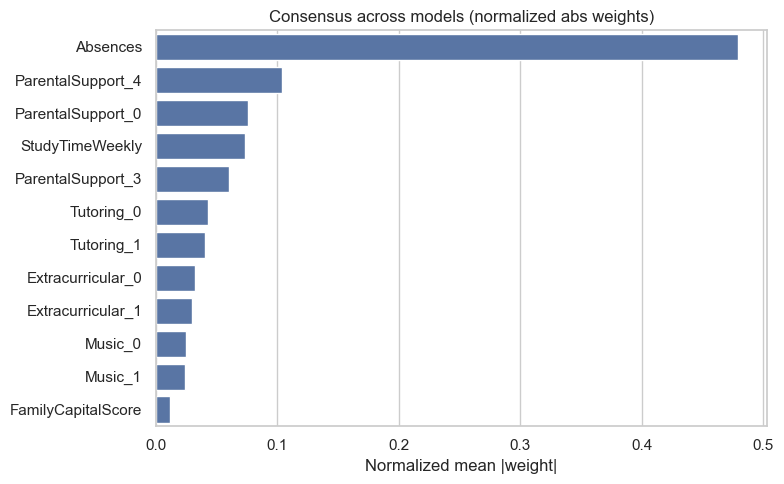

In [ ]:
# Get feature names after preprocessing + KBest
all_names, scores, mask, selected = preprocessing.get_selected_features(
    final_pipe, numeric_features, categorical_features
)

def plot_top(df, title, k=15):
    df_head = df.copy().sort_values("abs_weight", ascending=False).head(k)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_head, x="abs_weight", y="feature")
    plt.title(title)
    plt.xlabel("Absolute weight / importance")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# Coefficients — Ridge (tuned, final_pipe)
ridge_model = final_pipe.named_steps[
    [k for k in final_pipe.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
]
ridge_coef = np.ravel(getattr(ridge_model, "coef_", np.array([])))

ridge_df = pd.DataFrame({
    "feature": selected,
    "weight": ridge_coef,
    "abs_weight": np.abs(ridge_coef),
    "model": "Ridge (tuned)"
}).sort_values("abs_weight", ascending=False)

print("Ridge coefficients:")
display(ridge_df.head(20))
plot_top(ridge_df, "Top coefficients — Ridge (tuned)")

# Coefficients – Linear Regression (baseline)
lin_pipe = preprocessing.create_pipeline(
    numeric_features, categorical_features, k_best=12, model=LinearRegression()
)
lin_pipe.fit(X_train, y_train.squeeze())

_, _, _, sel_lin = preprocessing.get_selected_features(lin_pipe, numeric_features, categorical_features)
lin_coef = np.ravel(lin_pipe.named_steps[
    [k for k in lin_pipe.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
].coef_)

lin_df = pd.DataFrame({
    "feature": sel_lin,
    "weight": lin_coef,
    "abs_weight": np.abs(lin_coef),
    "model": "LinearRegression"
})

# Coefficients – ElasticNet (tuned)
elastic_pipe = preprocessing.create_pipeline(
    numeric_features, categorical_features, k_best=12,
    model=ElasticNet(alpha=elastic_best_params["model__alpha"],
                     l1_ratio=elastic_best_params["model__l1_ratio"],
                     max_iter=10000, random_state=42)
)
elastic_pipe.fit(X_train, y_train.squeeze())

_, _, _, sel_el = preprocessing.get_selected_features(elastic_pipe, numeric_features, categorical_features)
elastic_coef = np.ravel(elastic_pipe.named_steps[
    [k for k in elastic_pipe.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
].coef_)

elastic_df = pd.DataFrame({
    "feature": sel_el,
    "weight": elastic_coef,
    "abs_weight": np.abs(elastic_coef),
    "model": "ElasticNet (tuned)"
})

# Compare coefficients across the 3 linear models
linear_compare = (
    ridge_df[["feature", "weight"]].rename(columns={"weight": "ridge_w"})
    .merge(lin_df[["feature", "weight"]].rename(columns={"weight": "linear_w"}), on="feature", how="outer")
    .merge(elastic_df[["feature", "weight"]].rename(columns={"weight": "elastic_w"}), on="feature", how="outer")
    .fillna(0.0)
)
print("Coefficients across linear models:")
display(linear_compare.sort_values("ridge_w", key=np.abs, ascending=False).head(20))

# Feature importances — RandomForest
try:
    rf_best_pipe
    rf_pipe = rf_best_pipe
except NameError:
    rf_pipe = preprocessing.create_pipeline(
        numeric_features, categorical_features, k_best=12,
        model=RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    )
    rf_pipe.fit(X_train, y_train.squeeze())

_, _, _, sel_rf = preprocessing.get_selected_features(rf_pipe, numeric_features, categorical_features)
rf_model = rf_pipe.named_steps[
    [k for k in rf_pipe.named_steps if k not in ("preprocessor", "select", "feature_selector")][-1]
]
rf_imp = getattr(rf_model, "feature_importances_", np.zeros(len(sel_rf)))

rf_df = pd.DataFrame({
    "feature": sel_rf,
    "weight": rf_imp,
    "abs_weight": np.abs(rf_imp),
    "model": "RandomForest"
}).sort_values("abs_weight", ascending=False)

print("Random Forest Feature Importance:")
display(rf_df.head(20))
plot_top(rf_df, "Top importances — RandomForest")

# Consensus across models (normalize abs weights and average)
def norm_abs(w):
    s = np.sum(np.abs(w))
    return (np.abs(w)/s) if s > 0 else np.zeros_like(w)

tri = (
    pd.DataFrame({"feature": ridge_df["feature"], "ridge": norm_abs(ridge_df["weight"])})
    .merge(pd.DataFrame({"feature": lin_df["feature"], "linear": norm_abs(lin_df["weight"])}), on="feature", how="outer").fillna(0)
    .merge(pd.DataFrame({"feature": elastic_df["feature"], "elastic": norm_abs(elastic_df["weight"])}), on="feature", how="outer").fillna(0)
    .merge(pd.DataFrame({"feature": rf_df["feature"], "rf": norm_abs(rf_df["weight"])}), on="feature", how="outer").fillna(0)
)
tri["consensus_score"] = tri[["ridge", "linear", "elastic", "rf"]].mean(axis=1)
tri = tri.sort_values("consensus_score", ascending=False)

print("Consensus across models (normalized abs weights):")
display(tri.head(20))

plt.figure(figsize=(8,5))
sns.barplot(data=tri.head(15), x="consensus_score", y="feature")
plt.title("Consensus across models (normalized abs weights)")
plt.xlabel("Normalized mean |weight|")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [ ]:
# Extract coefficients from the final model (Ridge)
model = final_pipe.named_steps["model"]
coefs = getattr(model, "coef_", None)

expected = ['+', '-', '+', '-', '+', '-', '+', '+', '-', '+', '-', '+']
print("Sanity check model")
for i in range(0, len(selected)):
    actual_sign = '+' if coefs[i] > 0 else '-'
    match = "✅" if actual_sign == expected[i] else "❌"
    print(f"{selected[i]}: ({actual_sign}) {match}")

if coefs is not None:
    coef_df = pd.DataFrame({"feature": selected, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

    print("\nTop positive contributors (Ridge):")
    print(coef_df_sorted[coef_df_sorted["coef"] > 0].head(10).to_string(index=False))

    print("\nTop negative contributors (Ridge):")
    print(coef_df_sorted[coef_df_sorted["coef"] < 0].head(10).to_string(index=False))
else:
    print("Coefficients not available for this model type.")

Sanity check model
StudyTimeWeekly: (+) ✅
Absences: (-) ✅
FamilyCapitalScore: (+) ✅
Tutoring_0: (-) ✅
Tutoring_1: (+) ✅
ParentalSupport_0: (-) ✅
ParentalSupport_3: (+) ✅
ParentalSupport_4: (+) ✅
Extracurricular_0: (-) ✅
Extracurricular_1: (+) ✅
Music_0: (-) ✅
Music_1: (+) ✅

Top positive contributors (Ridge):
           feature     coef  abs_coef
 ParentalSupport_4 0.320065  0.320065
 ParentalSupport_3 0.184430  0.184430
   StudyTimeWeekly 0.170916  0.170916
        Tutoring_1 0.124540  0.124540
 Extracurricular_1 0.093224  0.093224
           Music_1 0.075092  0.075092
FamilyCapitalScore 0.020836  0.020836

Top negative contributors (Ridge):
          feature      coef  abs_coef
         Absences -0.830968  0.830968
ParentalSupport_0 -0.230853  0.230853
       Tutoring_0 -0.124540  0.124540
Extracurricular_0 -0.093224  0.093224
          Music_0 -0.075092  0.075092


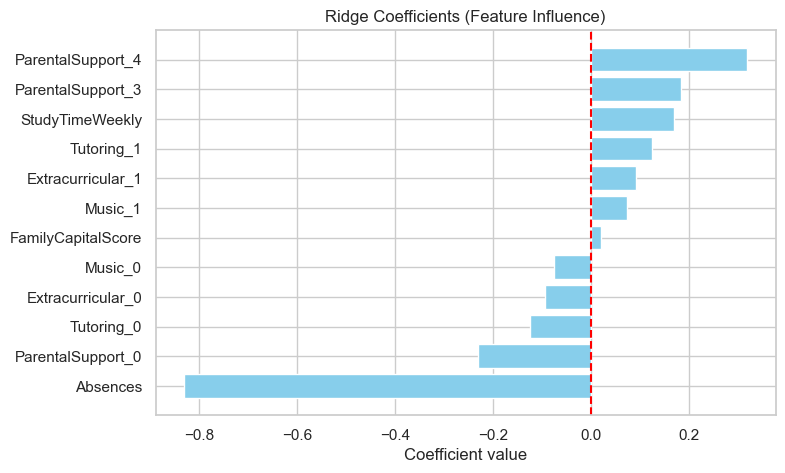

In [ ]:
coef_df = pd.DataFrame({"feature": selected, "coef": model.coef_})
coef_df = coef_df.sort_values("coef", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(coef_df["feature"], coef_df["coef"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Coefficient value")
plt.title("Ridge Coefficients (Feature Influence)")
plt.gca().invert_yaxis()
plt.show()

**Feature Insights - Coefficients & Importances**

**Ridge coefficients (tuned)**
- **Absences** has the strongest effect and is **negative**: more absences → lower predicted outcome.  
- **ParentalSupport** shows a gradient:  
  - Strong support (level 4) → **positive contribution**  
  - No support (0) → **negative contribution**  
  - Intermediate support (3) → **positive contribution**  
- **StudyTimeWeekly** is **positive**: more study time → higher outcome.  
- **Tutoring**, **Extracurriculars**, and **Music** appear as dummy pairs (0/1) with opposite coefficients. The direction indicates participation (1) tends to be slightly beneficial.  
- **FamilyCapitalScore** has a small positive coefficient but is not a major driver.

**Across linear models (Ridge, Linear Regression, ElasticNet)**
- Coefficients are almost **identical across all three models**.  
- Signals are consistent: **Absences negative**, **ParentalSupport positive**, **StudyTime positive**.  
- This indicates results are **robust to the choice of linear regularization**.

**Random Forest importances**
- **Absences dominates** (importance ≈0.85).  
- **StudyTimeWeekly** is the second most important (≈0.07).  
- All other features (ParentalSupport, Tutoring, Extracurriculars, Music) have **very low importance scores**.  
- The tree-based model highlights that predictions are **driven primarily by Absences**, with StudyTime as a secondary factor.

**Consensus view**
- **Absences** is the top predictor across *all* models.  
- **StudyTimeWeekly** is consistently important across both linear and tree models.  
- **ParentalSupport** is meaningful in linear models but muted in Random Forest.  
- **Tutoring, Extracurriculars, Music, FamilyCapitalScore** play only a minor role.

**Overall takeaway:**  
Model families with different biases (linear vs. tree-based) converge on the same message:  
**Absences** are the dominant driver of performance, followed by **StudyTime** and, to a lesser extent, **ParentalSupport**. 

**Business applications**

- **Resource allocation**: focus interventions where the impact is strongest (e.g., reducing absences).  
- **Data collection**: prioritize accurate measurement of features that matter most (e.g., study time).  
- **Process improvement**: target influential operational factors (e.g., parental support programs) to maximize outcomes.


**Permutation Importance**

Coefficients tell me how strongly features are associated with GPA in a linear sense, but they can be misleading because:
- They depend on the scaling of features.
- Correlated features can share or “hide” influence.
- A large coefficient doesn’t always mean the feature is the most impactful in practice.

Permutation importance complements coefficient analysis by directly measuring how much the model’s performance drops when each feature is randomly shuffled.  
This shows the *actual predictive contribution* of each feature, regardless of scaling or collinearity.

In [ ]:
# Transform X_test the same way the pipeline does
pre = final_pipe.named_steps["preprocessor"]
X_tx = pre.transform(X_test)

sel = final_pipe.named_steps.get("select", None)
if sel is not None and sel != "passthrough":
    X_tx = sel.transform(X_tx)

# 3) Use the final model (not the whole pipeline)
model = final_pipe.named_steps["model"]

# 4) Permutation importance on the transformed matrix
perm = permutation_importance(
    model,
    X_tx,
    np.ravel(y_test),
    n_repeats=10,
    random_state=42,
    scoring="r2",
)

# 5) Build a matching DataFrame
pi = pd.DataFrame({
    "feature": selected,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False)

print(pi.head(15).to_string(index=False))

           feature  importance_mean  importance_std
          Absences         1.737226        0.077994
   StudyTimeWeekly         0.053542        0.005594
 ParentalSupport_4         0.025672        0.002148
 ParentalSupport_3         0.017492        0.002078
        Tutoring_0         0.007164        0.001058
        Tutoring_1         0.007164        0.001058
 ParentalSupport_0         0.006274        0.000987
 Extracurricular_0         0.004162        0.000599
 Extracurricular_1         0.004162        0.000599
FamilyCapitalScore         0.001312        0.000421
           Music_0         0.000609        0.000664
           Music_1         0.000609        0.000664


**Results**

- **Absences** is by far the most important feature (importance ≈ 1.74). This confirms what coefficients already suggested: more absences strongly reduce GPA.  
- **StudyTimeWeekly** also contributes positively, though with a much smaller importance (~0.05).  
- **ParentalSupport_4** and **ParentalSupport_3** appear among the top contributors (0.026 and 0.017), aligning with their positive coefficients.  
- Features like **Tutoring**, **Extracurriculars**, and **Music** show small but non-negligible contributions.  
- **FamilyCapitalScore** and **Music** categories have very low importance, suggesting little direct impact on prediction.

**Takeaway**

The Ridge coefficients and permutation importance are consistent in highlighting:
- *Absences* as the strongest negative driver of GPA.
- *ParentalSupport* and *StudyTimeWeekly* as the most valuable positive supports. Permutation importance adds confidence that these aren’t just statistical artifacts of scaling but genuinely influential for prediction.

### 3.7 - TEST SET EVALUATION

After tuning and finalizing the Ridge model on the training data, I now evaluate it on the hold-out test set.  
This step provides an **unbiased estimate** of how well the model generalizes to unseen students.

**Test performance metrics**  
- **RMSE (Root Mean Squared Error)**: measures the average size of prediction errors. Lower = better.  
- **MAE (Mean Absolute Error)**: the average absolute error, easier to interpret in GPA units.  
- **R² (Coefficient of Determination)**: proportion of variance in GPA explained by the model (1 = perfect fit, 0 = no better than mean prediction).

**Intercept**  
The intercept is the baseline prediction when all features = 0.  
Because features are standardized in the pipeline, "0" means “exactly average” on each variable.  
So the intercept represents the predicted GPA of a *typical average student*.  
If residuals are centered around 0, it means the model captures the mean well.

**Model prediction vs feature (e.g. Absences)**  
- Finally, by fitting a line to a single feature (e.g., *Absences*), while holding all others constant, I can see how GPA decreases as absences increase. This makes the model’s logic more interpretable and connects coefficients with real outcomes.

Final Ridge on test:
RMSE: 0.2184 | MAE: 0.1740 | R²: 0.9443
Model explains 94.4% of the variation
✅ Good model!

Model Parameters:
Intercept: 1.956


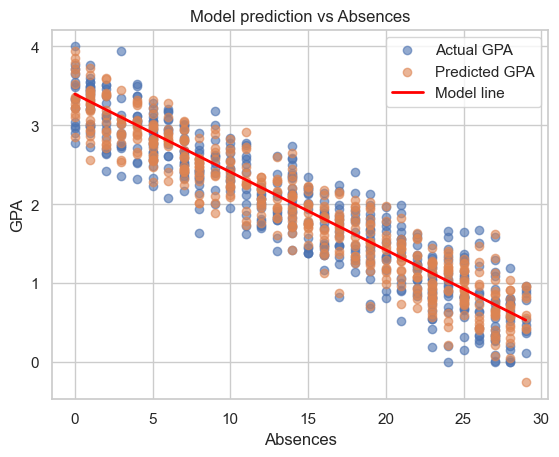

In [ ]:
# --- Evaluate final Ridge pipeline on test set ---
y_pred = final_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Final Ridge on test:")
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
print(f"Model explains {r2*100:.1f}% of the variation")
if r2 > 0.7:
    print("✅ Good model!")
elif r2 > 0.5:
    print("⚠️ Okay model")
else:
    print("❌ Needs improvement")

# --- Model reading (intercept + coefficients) ---
model = final_pipe.named_steps["model"]  # the Ridge regressor inside your pipeline
print("\nModel Parameters:")
print(f"Intercept: {model.intercept_:.3f}")

import numpy as np
import matplotlib.pyplot as plt

feature = "Absences"

# Sort feature values (Absence)
X_feature = X_test[[feature]].values
y_true = y_test.values
y_pred = final_pipe.predict(X_test)

plt.scatter(X_feature, y_true, alpha=0.6, label="Actual GPA")
plt.scatter(X_feature, y_pred, alpha=0.6, label="Predicted GPA")

# Fit a line on the feature data (1D only to visualize the actual model)
X_line = np.linspace(X_feature.min(), X_feature.max(), 100).reshape(-1, 1)
X_line_df = pd.DataFrame(X_line, columns=[feature])
y_line = final_pipe.predict(
    X_line_df.assign(**{col: X_test[col].mean() for col in X_test.columns if col != feature})
)

plt.plot(X_line, y_line, color="red", linewidth=2, label="Model line")
plt.xlabel(feature)
plt.ylabel("GPA")
plt.title(f"Model prediction vs {feature}")
plt.legend()
plt.show()

**Test Set Results**

The final Ridge regression achieves RMSE ≈ 0.218, MAE ≈ 0.174, and R² ≈ 0.944 on the test set.  

This confirms excellent predictive performance: errors are small, and the model explains about 94% of the variance in GPA.

Below I am saving the result onto a .md report file. 

In [ ]:
# Get rmse, mae, r2 and have final_pipe, ridge_best_params
all_names, scores, mask, selected = preprocessing.get_selected_features(final_pipe, numeric_features, categorical_features)

# Create dict with final results
report = {
    "Final Model Report – Ridge Regression": {
        "Best Parameters": {
            "alpha": float(ridge_best_params["model__alpha"]),
            "k_best": 12
        },
        "Test Set Metrics": {
            "RMSE": float(rmse),
            "MAE":  float(mae),
            "R2":   float(r2),
        },
        "Features": {
            "Numeric": numeric_features,
            "Categorical": categorical_features,
            "Selected After Fit": selected
        },
        "Notes": (
            "Ridge tuned with 5-fold CV. "
            f"Generalizes well (R²≈{r2:.3f}). "
            "Linear models outperform non-linear ones in this dataset."
        )
    }
}

# Saves to .md file
utils.save_report_md(report, "final_ridge_report.md")

Report saved to: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\outputs\reports\final_ridge_report.md


WindowsPath('C:/Users/Vaccari/Desktop/iCloudDrive/Desktop/ENRICO/05_LEARNING/University/ToU/Phases/02_Calibration_Phase/Applied_Machine_Learning/Regression/beyond-grades-ml-project/outputs/reports/final_ridge_report.md')

### 3.6 - Diagnostic & Intepretation

**Residuals**

- **Predicted vs Actual GPA (parity plot):** each point is a student; points close to the diagonal line mean accurate predictions.  
- **Residuals vs Predicted GPA:** shows prediction errors against predicted values; a random scatter around zero means no systematic bias.  
- **Residuals Histogram:** shows the distribution of errors; if centered near zero with most values small, the model is usually very close.
- **QQ Plot of Residuals:** compares residuals to a normal distribution; if points lie on the diagonal, the errors follow an approximately normal pattern.

In [ ]:
# Residuals

res_df = preprocessing.make_residuals_df(final_pipe, X_test, y_test)

res_df.head()

print("Residual Analysis:")
print(f"Average residual: {res_df["residual"].mean():.3f}")
print(f"Largest error: {abs(res_df["residual"]).max():.3f}")
print(f"Standard deviation: {res_df["residual"].std():.3f}")

Residual Analysis:
Average residual: -0.009
Largest error: 1.049
Standard deviation: 0.218


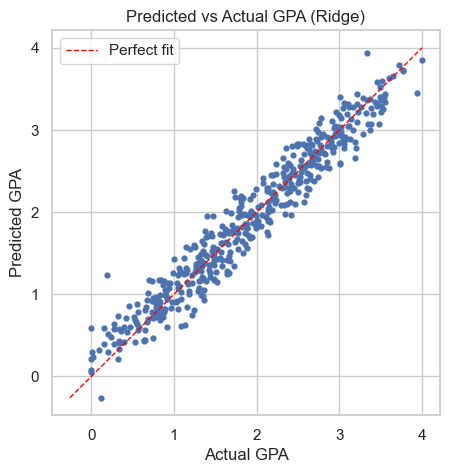

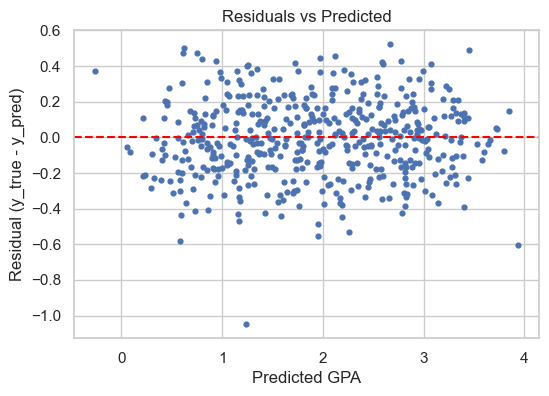

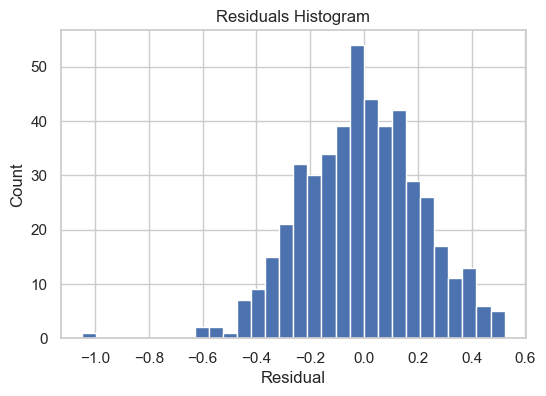

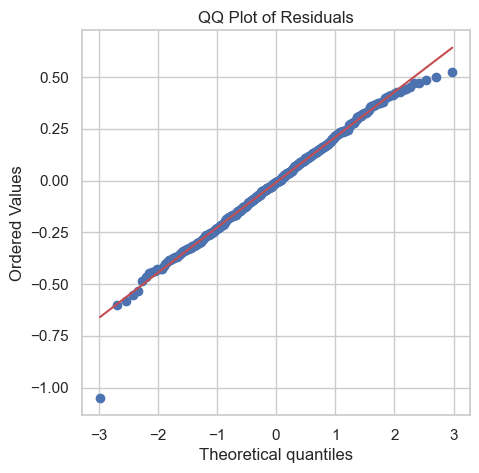

In [ ]:
# Parity Plot (Predicted vs Actual)
plt.figure(figsize=(5,5))
plt.scatter(res_df["y_true"], res_df["y_pred"], s=12)
min_v = min(res_df["y_true"].min(), res_df["y_pred"].min())
max_v = max(res_df["y_true"].max(), res_df["y_pred"].max())
plt.plot([min_v, max_v], [min_v, max_v],color="red", linestyle="--", lw=1, label="Perfect fit")
plt.xlabel("Actual GPA")
plt.ylabel("Predicted GPA")
plt.title("Predicted vs Actual GPA (Ridge)")
plt.legend()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(res_df["y_pred"], res_df["residual"], s=12)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted GPA")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Predicted")
plt.show()

# Residuals Histogram
plt.figure(figsize=(6,4))
plt.hist(res_df["residual"], bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.show()

# QQ-plot (optional)
try:
    from scipy import stats
    plt.figure(figsize=(5,5))
    stats.probplot(res_df["residual"], dist="norm", plot=plt)
    plt.title("QQ Plot of Residuals")
    plt.show()
except Exception as e:
    print("QQ plot skipped (scipy not available):", e)

**Diagnostic Results**

- **Predicted vs Actual GPA:** points lie tightly on the diagonal, confirming high accuracy.  
- **Residuals vs Predicted GPA:** errors scatter randomly around zero, with just a few outliers — no systematic bias detected.  
- **Residuals Histogram:** residuals are centered near zero, showing most predictions are close to the true GPA; only a handful of larger errors exist.  
- **QQ Plot:** points align almost perfectly on the diagonal, confirming residuals are close to normally distributed, with only a few deviations (some outliers in the top-right and one in the bottom-left).


**Error Analysis by Subgroups**

To check if the model behaves fairly across different student groups, I compare RMSE and MAE per subgroup (e.g., 'ParentalEducation', 'Sports', 'Ethnicity').  
If some groups show much higher errors, that may indicate potential bias or weaker generalization.

In [ ]:
# Pick relevant groups from your dataset
group_cols = ["Gender", "ParentalEducation", "Ethnicity", "Extracurricular", "Sports", "Music", "Volunteering"]

group_reports = {}
for gc in group_cols:
    if gc in X_test.columns:
        group_reports[gc] = preprocessing.evaluate_by_group(final_pipe, X_test, y_test, gc)

# Usage: check the most "unbalanced" groups
print("RMSE differences across groups:")
display(preprocessing.summarize_group_reports(group_reports, metric="RMSE"))

print("\nMAE differences across groups:")
display(preprocessing.summarize_group_reports(group_reports, metric="MAE"))

RMSE differences across groups:


,Group,Min_RMSE,Max_RMSE,Gap
1,ParentalEducation,0.205730,0.262251,0.056521
4,Sports,0.205559,0.250356,0.044797
2,Ethnicity,0.193330,0.226318,0.032988



MAE differences across groups:


,Group,Min_MAE,Max_MAE,Gap
1,ParentalEducation,0.164836,0.223244,0.058408
4,Sports,0.163186,0.203821,0.040635
2,Ethnicity,0.160205,0.188217,0.028012


**Results (RMSE gaps)**

- 'ParentalEducation' shows the largest gap (≈0.057), meaning prediction errors vary the most depending on parents' education.  
- 'Sports' follows with a gap of ≈0.045.  
- 'Ethnicity' has a smaller gap of ≈0.033.  
Overall, the differences are moderate, but they suggest the model is slightly less accurate for some subgroups.

**Results (MAE gaps)**

- 'ParentalEducation' again shows the largest gap (≈0.058).  
- 'Sports' shows a smaller gap (≈0.041).  
- 'Ethnicity' shows the smallest gap (≈0.028).  
The consistency of results across RMSE and MAE highlights that parental education level is the most influential subgroup for model accuracy.

**Understanding and Finalizing the Chosen Model**

Interpreting a regression model is not only about checking numbers like RMSE or R². It’s about building a full picture of how the model works, why it predicts the way it does, and where it might fall short.  
This involves several layers of analysis:

- **Performance metrics**: RMSE, MAE, and R² show overall accuracy and variance explained.  
- **Coefficients**: quantify the direction and relative strength of each predictor’s impact.  
- **Residuals**: highlight where the model struggles, often pointing to areas for improvement.  
- **Subgroup analysis**: checks whether the model performs equally well across different populations (fairness).  
- **Permutation importance**: validates which features truly drive predictive performance.

Taken together, these diagnostics confirm that Ridge regression is a reliable choice for predicting GPA.  
It balances accuracy (R² ≈ 0.94 on test) with interpretability, making it both effective and transparent.  

Let's think of a real world analysis: in education policy, such a model can guide where to allocate resources.

>- For example, if *absences* strongly reduce GPA, interventions could focus on attendance support.  
>- If *study time* or *parental support* emerge as positive factors, schools can design programs to encourage these.

### 3.9 - TESTS
For en extra proof of reliabilty, I have checked the following assumptions on my best modelv (Ridge):

>- Linear relationship between inputs and output.
>- Residuals are randomly distributed.
>- No extreme outliers dominating the model.

In [ ]:
# Test assumptions

print("ASSUMPTION CHECKS")
print("="*20)

# Check 1: Linear relationship
correlation = np.corrcoef(res_df["y_pred"], res_df["residual"])[0, 1]
if abs(correlation) < 0.1:
    print("- Linear relationship looks good")
else:
    print("- May need non-linear terms")

# Check 2: Residual distribution
if abs(res_df["residual"].mean()) < 0.1:
    print("- Residuals centered at zero")
else:
    print("- Model may be biased")

# Check 3: Outliers
outlier_count = sum(abs(res_df["residual"]) > 2 * res_df["residual"].std())
if outlier_count < len(res_df["residual"]) * 0.05:
    print("- Few outliers detected")
else:
    print("- Many outliers - check data quality")

ASSUMPTION CHECKS
- Linear relationship looks good
- Residuals centered at zero
- Few outliers detected


In [ ]:
# Test model reliability through cross-validation

# Test model on different data subsets*
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print("CROSS-VALIDATION RESULTS")
print("="*30)
print(f"Individual scores: {cv_scores}")
print(f"Average score: {cv_scores.mean():.3f}")
print(f"Standard deviation: {cv_scores.std():.3f}")

# Interpretation*
if cv_scores.std() < 0.1:
    print("- Model performance is consistent")
else:
    print("- Model performance varies significantly")

if cv_scores.mean() > 0.7:
    print("- Good average performance")
else:
    print("- Performance needs improvement")

CROSS-VALIDATION RESULTS
Individual scores: [0.95023205 0.9548749  0.95516886 0.94625394 0.95920173]
Average score: 0.953
Standard deviation: 0.004
- Model performance is consistent
- Good average performance


### 3.10 - MODEL DEPLOYMENT

**Saving the Trained Model**

Once the best model has been trained and validated, I didn't want to retrain it every time. Instead, I saved the full pipeline (preprocessing + feature selection + Ridge model) into a file.  
Later, I can load it back instantly and use it for predictions - like taking a “snapshot” of the model’s brain after learning.

In [ ]:
# Path where we want to store the trained Ridge model
model_path = Path("../artifacts/final_ridge/ridge_pipeline.joblib")
model_path.parent.mkdir(parents=True, exist_ok=True)

# Save the full pipeline (preprocessor + selector + model)
joblib.dump(final_pipe, model_path)

print(f"Model saved to {model_path}")

Model saved to ..\artifacts\final_ridge\ridge_pipeline.joblib


### 3.9 - LOAD AND TEST MODEL

Once the best Ridge pipeline is trained and saved, I don’t need to retrain it each time.  
I can load the **full pipeline** (preprocessing + selection + model) and predict GPA on new students directly.

In [ ]:
# Load the saved pipeline (same schema as training features required)
loaded_pipe = joblib.load("../artifacts/final_ridge/ridge_pipeline.joblib")

# Example: predict on a small batch from X_test (or on any new X_new with same columns)
N = 10
y_pred_batch = loaded_pipe.predict(X_test.iloc[:N])
pred_df = pd.DataFrame({
    "index": X_test.index[:N],
    "Predicted_GPA": np.round(y_pred_batch, 3),
    "Real GPA": y_test.iloc[:N].values.ravel()  
})
print(pred_df.to_string(index=False))


 index  Predicted_GPA  Real GPA
     0          1.747  1.666702
     1          2.094  2.370067
     2          1.677  1.757092
     3          0.747  1.217873
     4          1.625  1.574306
     5          1.910  2.145849
     6          0.537  0.427569
     7          2.833  2.517229
     8          2.917  2.846487
     9          0.965  0.915712


**Flagging at-risk students (low predicted GPA)**

To make predictions actionable, I add a simple flag:
- I compute a **low-GPA threshold** from the training targets (e.g., 10th percentile).
- Any new prediction below this threshold is flagged as **⚠️ at-risk**.
- Optionally, I can use **subgroup-aware thresholds** (e.g., per 'ParentalEducation') to compare students fairly within similar contexts.

In [ ]:
# --- Make sure y_train is 1D (Series) ---
if isinstance(y_train, pd.DataFrame):
    y_train_1d = y_train.squeeze()          # -> Series
else:
    y_train_1d = pd.Series(np.ravel(y_train))

# Overall 10th percentile (global threshold)
p10_overall = float(y_train_1d.quantile(0.10))

# Optional: subgroup-aware threshold (example with ParentalEducation if available)
use_group = "ParentalEducation" if "ParentalEducation" in X_train.columns else None
if use_group:
    train_tmp = X_train[[use_group]].copy()
    train_tmp["GPA"] = y_train_1d.values
    p10_by_group = train_tmp.groupby(use_group)["GPA"].quantile(0.10).to_dict()
else:
    p10_by_group = {}

print("Overall p10:", round(p10_overall, 3))
if use_group:
    print("Per-group p10:", {k: round(v, 3) for k, v in p10_by_group.items()})


Overall p10: 0.694
Per-group p10: {0: 0.652, 1: 0.742, 2: 0.667, 3: 0.617, 4: 0.897}


In [ ]:
N = 10
batch_X = X_test.iloc[:N].copy()
batch_pred = loaded_pipe.predict(batch_X)

def mark_risk(row_pred, row_features):
    if use_group:
        grp = row_features.get(use_group, None)
        thr = p10_by_group.get(grp, p10_overall)
    else:
        thr = p10_overall
    return "⚠️" if row_pred < thr else ""

flags_df = pd.DataFrame({
    use_group if use_group else "Group": batch_X[use_group].values if use_group else ["-"] * len(batch_X),
    "Predicted_GPA": np.round(batch_pred, 3),
})
flags_df["RiskFlag"] = [
    mark_risk(pred, batch_X.iloc[i].to_dict()) for i, pred in enumerate(batch_pred)
]

print(flags_df.to_string(index=False))


 ParentalEducation  Predicted_GPA RiskFlag
                 1          1.747         
                 2          2.094         
                 3          1.677         
                 2          0.747         
                 1          1.625         
                 3          1.910         
                 2          0.537       ⚠️
                 2          2.833         
                 2          2.917         
                 2          0.965         


Each row shows:
- **'ParentalEducation'**: the subgroup used for a context-aware threshold.
- **'Predicted_GPA'**: model’s GPA estimate for that student.
- **'RiskFlag'**: ⚠️ if the prediction falls below the 10th-percentile threshold (either overall or the subgroup’s p10).

In the preview above, only **one student** is flagged (Predicted_GPA ≈ **0.537** in 'ParentalEducation' group **2**).  
All other predictions are above their respective thresholds and are **not** flagged.


**What this model enables in practice**

Our model can predict student GPA with high accuracy.  
This means educators can **identify at-risk students earlier**, prioritize timely support (e.g., attendance mentoring, study planning), and target resources where they matter most.

**Performance**: Ridge was selected for its balance of accuracy and stability (**R² ≈ 0.94, RMSE ≈ 0.218** on the test set).  
**Practical value**: In practice, this helps guide **interventions**, **counseling load**, and **program focus** (e.g., reducing absences, boosting study time, strengthening parental support).  
**In short**: This project shows how ML can turn routine school data into **actionable insights** that improve academic outcomes and equity.

**Visualizing flagged predictions**

To quickly spot potential at-risk students:

- A **scatter per subgroup** (e.g., 'ParentalEducation'): each dot is a predicted GPA; the horizontal line is the **10th percentile** threshold for that subgroup. Dots below the line get a ⚠️ flag.  
- A **bar chart** of the same predictions; bars with ⚠️ are highlighted so they stand out.

This makes it easy to see **which subgroups** contain more flagged students and **how far** predictions fall below typical levels for their context.


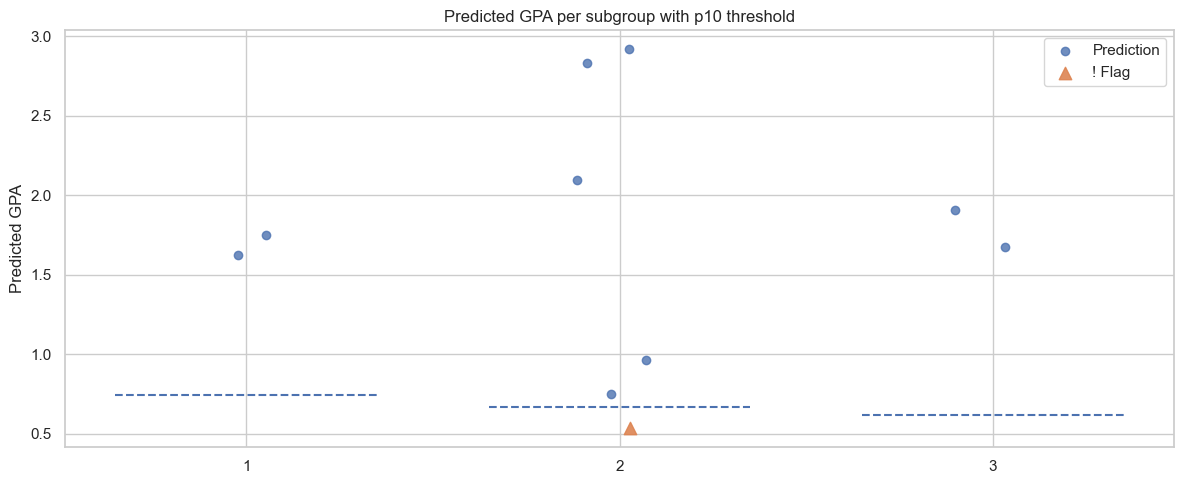

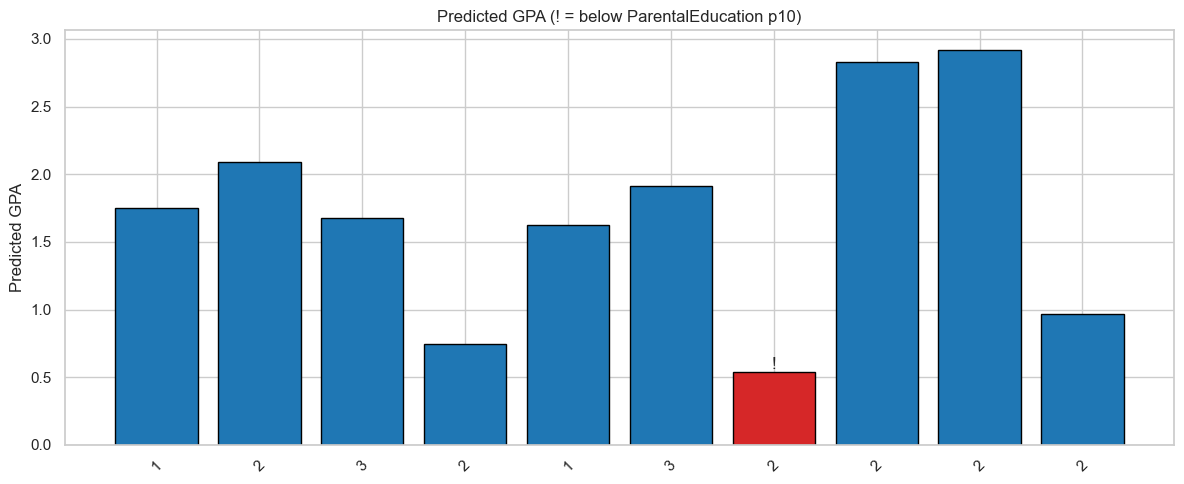

Alerts: 1 of 10 predictions flagged (below group p10).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse from previous steps:
# - flags_df with columns: ['ParentalEducation' (or 'Group'), 'Predicted_GPA', 'RiskFlag']
# - p10_overall (float) and p10_by_group (dict) if subgroup thresholds were computed
# If you used overall threshold only, set `use_group = None`.
use_group = "ParentalEducation" if "ParentalEducation" in flags_df.columns else None

# Convenience arrays
groups = flags_df[use_group].values if use_group else np.array(["-"] * len(flags_df))
preds  = flags_df["Predicted_GPA"].values
flags  = (flags_df["RiskFlag"] == "⚠️").values

# ---- 1) Scatter per subgroup with threshold lines ----
uniq_grp = list(dict.fromkeys(groups))  # preserve order of appearance
x_pos = np.array([uniq_grp.index(g) for g in groups], dtype=float)
x_jit = x_pos + np.random.uniform(-0.12, 0.12, size=len(x_pos))  # small jitter

plt.figure(figsize=(12,5))
# normal points
plt.scatter(x_jit[~flags], preds[~flags], alpha=0.8, label="Prediction")
# flagged points
plt.scatter(x_jit[flags], preds[flags], alpha=0.9, marker="^", s=80, label="! Flag")

# threshold per group (p10)
for i, g in enumerate(uniq_grp):
    thr = p10_by_group.get(g, p10_overall) if use_group else p10_overall
    if np.isfinite(thr):
        plt.hlines(thr, i-0.35, i+0.35, linestyles="dashed")

plt.xticks(range(len(uniq_grp)), uniq_grp, rotation=0)
plt.ylabel("Predicted GPA")
plt.title("Predicted GPA per subgroup with p10 threshold")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 2) Bar chart with flagged bars highlighted ----
plt.figure(figsize=(12,5))
idx = np.arange(len(preds))
colors = ["tab:red" if f else "tab:blue" for f in flags]
plt.bar(idx, preds, edgecolor="black", color=colors)

# add small markers (!) on flagged bars
for i, (p, f) in enumerate(zip(preds, flags)):
    if f:
        plt.text(i, p, "!", ha="center", va="bottom")

lbl = use_group if use_group else "Group"
plt.xticks(idx, [str(g) for g in groups], rotation=45)
plt.ylabel("Predicted GPA")
plt.title(f"Predicted GPA (! = below {lbl} p10)")
plt.tight_layout()
plt.show()

# Optional: quick alert summary
n_flags = flags.sum()
print(f"Alerts: {n_flags} of {len(preds)} predictions flagged (below {'group' if use_group else 'overall'} p10).")


---
# 4 - CONCLUSIONS

### 4.1 - OUTCOMES

Most predictions fall well above the 10th-percentile line for their subgroup, meaning they look normal.  
Only the points marked with ⚠️ (or !) stand out: these are students whose predicted GPA is unusually low compared to peers with similar background (e.g., same parental education).  

In the output table we see predicted GPA values per subgroup.  
Most predictions lie within expected ranges.  
For a few students, however, predicted GPA drops far below typical levels, so they were marked with a ⚠️ (or !) as potentially at risk.  

This shows the value of the flagging mechanism:

- Normal students pass without a flag.  
- Only those whose predicted outcomes are unusually low relative to their peers are highlighted.  

### 4.2 - LIMITATION, BIAS & ETHICAL REFLECTIONS

- **Dataset representation**: The dataset comes from a specific context (Pakistan) and may not reflect all education systems. Results might not generalize across countries or schools with different grading systems.  
- **Bias risk**: Social factors (e.g., gender roles, parental education) can reflect structural inequalities. If not handled carefully, the model may reproduce these biases rather than neutralize them.  
- **Overfitting risk**: Even with cross-validation and Ridge regularization, predictive performance may degrade on unseen populations if the data distributions shift.  
- **Transparency & reproducibility**: Pipelines, fixed seeds, and clean splits improve reproducibility and reduce leakage. Still, educators and policymakers should treat results as one tool among many, not a definitive judgment of individual students.  

### 4.3 - EXPLAINING MODEL TO STAKEHOLDERS

**32. Explaining the Model to Stakeholders**

**Enhanced Communication Framework**  
Statistical results need to be translated into actionable insights that different audiences can understand.  
- **Technical stakeholders** may want details about cross-validation, regularization, or residual distributions.  
- **Educational practitioners** (teachers, counselors) need clear explanations of *which factors most affect GPA* and how reliable the predictions are.  
- **School leadership or policymakers** benefit most from high-level summaries: *who is at risk, why it matters, and what interventions could help*.  

**Audience-Specific Approaches**  
- **Technical Audience**: Emphasize RMSE, R², model diagnostics, and fairness analysis.  
- **Educational Audience**: Show practical factors (absences, study time, parental support) and explain their relative impacts on GPA.  
- **Executive Audience**: Highlight the top risk factors, how many students are flagged at risk, and what actions (mentoring, attendance programs, parental engagement) can help.  

In [ ]:
print("MODEL EXPLANATION FOR STAKEHOLDERS")
print("="*40)
print(f"Model accuracy on test set: {r2*100:.1f}% (R²)")
print(f"Typical error: ±{mae:.2f} GPA points")

print("\nKey findings:")
for i in range(0, len(selected)):
    if coefs[i] > 0:
        print(f"• {selected[i]}: GPA increases by {coefs[i]:.2f} for each standardized unit increase")
    else:
        print(f"• {selected[i]}: GPA decreases by {abs(coefs[i]):.2f} for each standardized unit increase")

MODEL EXPLANATION FOR STAKEHOLDERS
Model accuracy on test set: 94.4% (R²)
Typical error: ±0.17 GPA points

Key findings:
• StudyTimeWeekly: GPA increases by 0.17 for each standardized unit increase
• Absences: GPA decreases by 0.83 for each standardized unit increase
• FamilyCapitalScore: GPA increases by 0.02 for each standardized unit increase
• Tutoring_0: GPA decreases by 0.12 for each standardized unit increase
• Tutoring_1: GPA increases by 0.12 for each standardized unit increase
• ParentalSupport_0: GPA decreases by 0.23 for each standardized unit increase
• ParentalSupport_3: GPA increases by 0.18 for each standardized unit increase
• ParentalSupport_4: GPA increases by 0.32 for each standardized unit increase
• Extracurricular_0: GPA decreases by 0.09 for each standardized unit increase
• Extracurricular_1: GPA increases by 0.09 for each standardized unit increase
• Music_0: GPA decreases by 0.08 for each standardized unit increase
• Music_1: GPA increases by 0.08 for each st